# Accompanying notebook to Optimization Stories in Logistics and Transportation

By Joaquim Gromicho, ORTEC & The Analytics Academy, 2020

## Els: a tiny bit of data science... 


We start by simulating two samples of observed wood lengths for `f` football trophies and `g` golf trophies.

In [1]:
%matplotlib inline

In [2]:
import numpy as np 
np.random.seed(2019)

n = 2000

f = np.random.lognormal(np.log(4.), .005, n)
g = np.random.lognormal(np.log(2.), .005, n)

In [3]:
print(f)
print(g)

[3.99564879 4.01646289 4.02973554 ... 4.01123905 3.99435904 3.97869576]
[2.02280781 2.00197065 1.98437689 ... 2.00435164 2.00058384 1.99004621]


In [4]:
print( min(f), max(f), min(g), max(g) )

3.9198236473295482 4.061099394419732 1.9693944256932012 2.0341408204151055


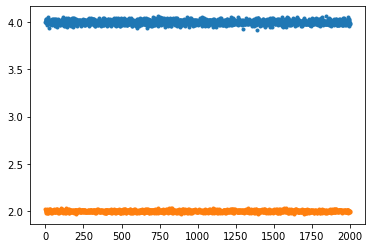

In [5]:
import matplotlib.pyplot as plt

plt.plot( f, '.' )
plt.plot( g, '.' )
plt.show()

What is the consequence of uncertainty? 
We compare the cumulative lengths with the nominal ones.

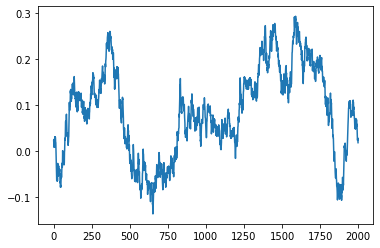

In [6]:
cs = np.cumsum(g) - np.cumsum( [2]*len(g) )
plt.plot(cs)
plt.show()

A very simple and somehow naïf uncertainty region can be taken as the observed minimal box around the data.

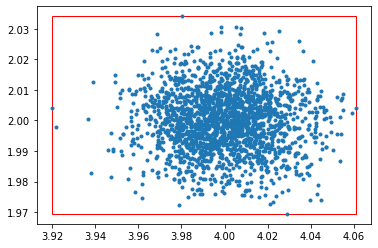

3.9198236473295482 4.061099394419732 1.9693944256932012 2.0341408204151055


In [7]:
import matplotlib.patches as patches

plt.figure()
plt.plot( f, g, '.' )
currentAxis = plt.gca()
currentAxis.add_patch(patches.Rectangle((min(f), min(g)), max(f)-min(f), max(g)-min(g),fill=False,color='r'))
plt.show()

print( min(f), max(f), min(g), max(g) )

## Fiona's robust model for box uncertainty in wood consumption

Suppose now that Caroline notices that not _exactly_ 4 and 2 dm of wood are used, but some fluctuations are observed.
Caroline wants to be __sure__ that her model does not violate the wood constraint, therefore the following should hold:

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
s.t.    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & a_1 x_1 & + & a_2 x_2 & \leq & 4800 & \forall \ell \leq a \leq u \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

***

A bit of linear duality (or even better: an introduction to robust optimization!) helps Caroline how to deal with the above model that has an infinite number of constraints.
The first thing to notice is that the wood consumption is modeled by constraints that are equivalent to bounding the following optimization problem:
    
$$
\begin{array}{rrr}
\max    & x_1 a_1 + x_2 a_2 & \leq 4800 \\
s.t.    & \ell \leq a \leq u 
\end{array}
$$

Or

$$
\begin{array}{rrr}
\max    & x_1 a_1 + x_2 a_2 & \leq 4800 \\
s.t.    & a \leq u \\
        & -a \leq -\ell 
\end{array}
$$

Now we use linear duality to realize that the above is equivalent to:
 
$$
\begin{array}{rrr}
\min    & u y  - \ell w & \leq 4800 \\
s.t.    & y - w = x \\
        & y \geq 0, w \geq 0
\end{array}
$$
    
and the constraint imposed by the last problem is equivalent to:

$$
\begin{array}{rrl}
   & u y  - \ell w & \leq 4800 \\
   & y - w & = x \\
   & y \geq 0, w \geq 0
\end{array}
$$

The only thing we need to do is add variables and constraints to Caroline's model.

In [8]:
import pyomo.environ as pyo

trophies = [ 'Football', 'Golf' ]
profits  = { 'Football' : 12, 'Golf' :  9 }
wood     = { 'Football' :  4, 'Golf' :  2 }

Caroline = pyo.ConcreteModel('Caroline')

Caroline.x = pyo.Var(trophies,within=pyo.NonNegativeReals)

Caroline.profit    = pyo.Objective(expr = sum([profits[t]*Caroline.x[t] for t in trophies]), sense=pyo.maximize)

Caroline.footballs = pyo.Constraint(expr = Caroline.x['Football']  <= 1000)
Caroline.golfBalls = pyo.Constraint(expr = Caroline.x['Golf']      <= 1500)
Caroline.plaques   = pyo.Constraint(expr = sum([Caroline.x[t] for t in trophies]) <= 1750)
Caroline.wood      = pyo.Constraint(expr = sum([wood[t]*Caroline.x[t] for t in trophies]) <= 4800)
 
from pyomo.opt import SolverFactory
%time results = SolverFactory('glpk').solve(Caroline)
print(results.solver.status, results.solver.termination_condition )

print(Caroline.profit.expr())

Caroline.display()

Wall time: 400 ms
ok optimal
17700.0
Model Caroline

  Variables:
    x : Size=2, Index=x_index
        Key      : Lower : Value  : Upper : Fixed : Stale : Domain
        Football :     0 :  650.0 :  None : False : False : NonNegativeReals
            Golf :     0 : 1100.0 :  None : False : False : NonNegativeReals

  Objectives:
    profit : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 17700.0

  Constraints:
    footballs : Size=1
        Key  : Lower : Body  : Upper
        None :  None : 650.0 : 1000.0
    golfBalls : Size=1
        Key  : Lower : Body   : Upper
        None :  None : 1100.0 : 1500.0
    plaques : Size=1
        Key  : Lower : Body   : Upper
        None :  None : 1750.0 : 1750.0
    wood : Size=1
        Key  : Lower : Body   : Upper
        None :  None : 4800.0 : 4800.0


In [9]:
def CarolineWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeReals ):
    import pyomo.environ as pyo

    trophies = [ 'Football', 'Golf' ]
    profits  = { 'Football' : 12, 'Golf' :  9 }

    Caroline = pyo.ConcreteModel('Caroline')

    Caroline.x = pyo.Var(trophies,within=domain)

    Caroline.profit    = pyo.Objective(expr = sum([profits[t]*Caroline.x[t] for t in trophies]), sense=pyo.maximize)

    Caroline.footballs = pyo.Constraint(expr = Caroline.x['Football']  <= 1000)
    Caroline.golfBalls = pyo.Constraint(expr = Caroline.x['Golf']      <= 1500)
    Caroline.plaques   = pyo.Constraint(expr = sum([Caroline.x[t] for t in trophies]) <= 1750)

    Caroline.y = pyo.Var(trophies,domain=pyo.NonNegativeReals)
    Caroline.w = pyo.Var(trophies,domain=pyo.NonNegativeReals)

    Caroline.robustWood = pyo.Constraint(expr = sum([upper[t]*Caroline.y[t] - lower[t]*Caroline.w[t] for t in trophies]) <= 4800)

    def PerVariable( model, t ):
        return model.x[t] == model.y[t] - model.w[t] 
    
    Caroline.perVariable = pyo.Constraint(trophies,rule=PerVariable)

    return Caroline

In [10]:
lower = upper = {}
lower['Football'] = min(f)
upper['Football'] = max(f)
lower['Golf'] = min(g)
upper['Golf'] = max(g)

Caroline = CarolineWithBoxUncertainty( lower, upper )

%time results = SolverFactory('glpk').solve(Caroline)
print(results.solver.status, results.solver.termination_condition )

print(Caroline.profit.expr())

Caroline.display()

Wall time: 178 ms
ok optimal
17585.637264884834
Model Caroline

  Variables:
    x : Size=2, Index=x_index
        Key      : Lower : Value            : Upper : Fixed : Stale : Domain
        Football :     0 : 611.879088294941 :  None : False : False : NonNegativeReals
            Golf :     0 : 1138.12091170506 :  None : False : False : NonNegativeReals
    y : Size=2, Index=y_index
        Key      : Lower : Value            : Upper : Fixed : Stale : Domain
        Football :     0 : 611.879088294941 :  None : False : False : NonNegativeReals
            Golf :     0 : 1138.12091170506 :  None : False : False : NonNegativeReals
    w : Size=2, Index=w_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
        Football :     0 :   0.0 :  None : False : False : NonNegativeReals
            Golf :     0 :   0.0 :  None : False : False : NonNegativeReals

  Objectives:
    profit : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :

In [11]:
# you can play with the amount of uncertainty. 
# In particular, if below you make delta equal to 0 you obtain the same result als the  nominal model.
delta = 0.001

lower = wood.copy()
upper = wood.copy()

for i in trophies:
    lower[i] = wood[i] - delta
    upper[i] = wood[i] + delta
    
Caroline = CarolineWithBoxUncertainty( lower, upper )

%time results = SolverFactory('glpk').solve(Caroline)
print(results.solver.status, results.solver.termination_condition )

print(Caroline.profit.expr())

Caroline.display()

Wall time: 199 ms
ok optimal
17697.375
Model Caroline

  Variables:
    x : Size=2, Index=x_index
        Key      : Lower : Value    : Upper : Fixed : Stale : Domain
        Football :     0 :  649.125 :  None : False : False : NonNegativeReals
            Golf :     0 : 1100.875 :  None : False : False : NonNegativeReals
    y : Size=2, Index=y_index
        Key      : Lower : Value    : Upper : Fixed : Stale : Domain
        Football :     0 :  649.125 :  None : False : False : NonNegativeReals
            Golf :     0 : 1100.875 :  None : False : False : NonNegativeReals
    w : Size=2, Index=w_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
        Football :     0 :   0.0 :  None : False : False : NonNegativeReals
            Golf :     0 :   0.0 :  None : False : False : NonNegativeReals

  Objectives:
    profit : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 17697.375

  Constraints:
    footballs : Size=1
       

# Integer optimization

Caroline's model gave integer solutions, but not the robust version. 
If we need integer solutions then we should impose that to the nature of the variables, which in this case of _box uncertainty_ is easy to do since the model remains linear, although it will be mixed integer. 

In [12]:
Caroline = CarolineWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeIntegers )

%time results = SolverFactory('glpk').solve(Caroline)
print(results.solver.status, results.solver.termination_condition )

print(Caroline.profit.expr())

Caroline.display()

Wall time: 207 ms
ok optimal
17697.0
Model Caroline

  Variables:
    x : Size=2, Index=x_index
        Key      : Lower : Value  : Upper : Fixed : Stale : Domain
        Football :     0 :  649.0 :  None : False : False : NonNegativeIntegers
            Golf :     0 : 1101.0 :  None : False : False : NonNegativeIntegers
    y : Size=2, Index=y_index
        Key      : Lower : Value          : Upper : Fixed : Stale : Domain
        Football :     0 : 773.9999999999 :  None : False : False : NonNegativeReals
            Golf :     0 :         1101.0 :  None : False : False : NonNegativeReals
    w : Size=2, Index=w_index
        Key      : Lower : Value          : Upper : Fixed : Stale : Domain
        Football :     0 : 124.9999999999 :  None : False : False : NonNegativeReals
            Golf :     0 :            0.0 :  None : False : False : NonNegativeReals

  Objectives:
    profit : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 17697.0

  Co

We can also go a few cells back and try different values of `delta`.